In [1]:
import torch 
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [5]:
training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root = "data",
    train = False,
    download=True,
    transform=transform
)

100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [06:32<00:00, 435kB/s]


In [7]:
len(training_data)

50000

In [9]:
len(test_data)

10000

In [59]:
img,label = training_data[49999]

In [61]:
img

tensor([[[ 0.7961,  0.8510,  0.8353,  ...,  0.7020,  0.7333,  0.7412],
         [ 0.7412,  0.8745,  0.8275,  ...,  0.7490,  0.7804,  0.6471],
         [ 0.6706,  0.8353,  0.8118,  ...,  0.7255,  0.7255,  0.5843],
         ...,
         [ 0.1765,  0.0980,  0.0353,  ...,  0.7569,  0.8039,  0.8902],
         [ 0.0745,  0.0196, -0.0196,  ...,  0.4196,  0.5843,  0.6627],
         [-0.0431, -0.0745, -0.0588,  ...,  0.4039,  0.2863,  0.2784]],

        [[ 0.7961,  0.8588,  0.8510,  ...,  0.7176,  0.7490,  0.7490],
         [ 0.7333,  0.8745,  0.8353,  ...,  0.7490,  0.7882,  0.6549],
         [ 0.6157,  0.8196,  0.8275,  ...,  0.7255,  0.7176,  0.5922],
         ...,
         [ 0.1216,  0.0588, -0.0039,  ...,  0.7412,  0.7882,  0.8902],
         [ 0.0353, -0.0039, -0.0510,  ...,  0.4118,  0.5765,  0.6549],
         [-0.0667, -0.0902, -0.0902,  ...,  0.3882,  0.2863,  0.2784]],

        [[ 0.8745,  0.9373,  0.9373,  ...,  0.8275,  0.8353,  0.8275],
         [ 0.7961,  0.9529,  0.9294,  ...,  0

In [63]:
label

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


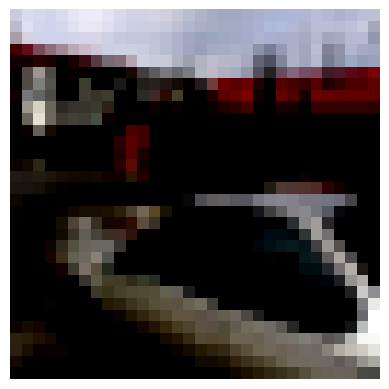

In [65]:
img_corrected = img.permute(1,2,0)

plt.imshow(img_corrected)
plt.axis("off")
plt.show()

In [69]:
from torch.utils.data import DataLoader

In [77]:
train_data_loader = DataLoader(training_data,batch_size=100,shuffle = True)
test_data_loader = DataLoader(test_data,batch_size=100,shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.99215686].


Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100])


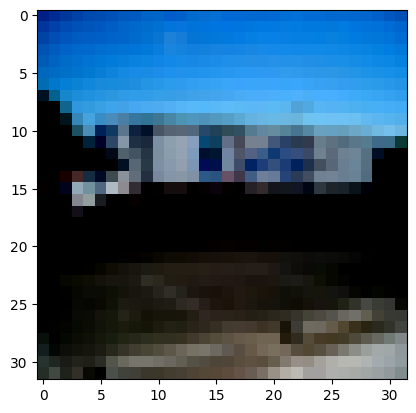

Label: 9


In [79]:
# Display image and label.
train_features, train_labels = next(iter(train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img_corrected = img.permute(1,2,0)
label = train_labels[0]
plt.imshow(img_corrected)
plt.show()
print(f"Label: {label}")

In [97]:
import torch.nn as nn
import torch.optim as optim

In [105]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=(3,3),padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(32,64,kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),

            nn.Flatten(),
            nn.Linear(64*7*7,600),
            nn.ReLU(),

            nn.Linear(600,120),
            nn.ReLU(),

            nn.Linear(120,10)
        )

    def forward(self,x):
        return self.network(x)

In [107]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [111]:
epochs = 20

In [113]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = model.to(device)

for epoch in range(epochs):
    losses = 0.0
    for image, label in train_data_loader:
        # Move data to device
        image, label = image.to(device), label.to(device)

        # forward pass
        output = model(image)
        loss = criterion(output, label)
        losses += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # weights update
        optimizer.step()

    print(f"for epoch {epoch+1} : loss is {(losses/len(train_data_loader)):.2f}")


Using device: cuda
for epoch 1 : loss is 1.40
for epoch 2 : loss is 0.98
for epoch 3 : loss is 0.78
for epoch 4 : loss is 0.63
for epoch 5 : loss is 0.49
for epoch 6 : loss is 0.36
for epoch 7 : loss is 0.25
for epoch 8 : loss is 0.15
for epoch 9 : loss is 0.11
for epoch 10 : loss is 0.09
for epoch 11 : loss is 0.07
for epoch 12 : loss is 0.07
for epoch 13 : loss is 0.06
for epoch 14 : loss is 0.05
for epoch 15 : loss is 0.06
for epoch 16 : loss is 0.04
for epoch 17 : loss is 0.05
for epoch 18 : loss is 0.04
for epoch 19 : loss is 0.05
for epoch 20 : loss is 0.04


In [115]:
# Set model to evaluation mode
model.eval()

total = 0 
correct = 0 

with torch.no_grad():
    for images, labels in test_data_loader:
        # Move to device (GPU if available)
        images, labels = images.to(device), labels.to(device)

        # forward pass
        out = model(images)
        _, predicted = torch.max(out.data, 1)

        # count correct predictions
        pred_count = (predicted == labels).sum().item()
        correct += pred_count
        total += labels.size(0)

accuracy = (correct * 100 / total)
print(f"Accuracy is: {accuracy:.2f}%")


Accuracy is: 72.37%
